## There is a small problem in codes at part #(1) and #(2) and part the array generated by  #(2) might cause huge errors in visualization screen
** Part 2 is verified,no errors!
** Part1 is fixed by changing the creation orders of coordinates of viewing screen

##      //The main skeleton of the code is finished,now I am dealing with debugging//
Main index problem in B field calculation (matrix part,not the function!)

## To calculate magnetic field of each dipole from distance r,we use 
$\mathbf{B}(\mathbf{r}) = \nabla \times \mathbf{A} = \frac{\mu_0}{4\pi} \left[ \frac{3\mathbf{r}(\mathbf{m} \cdot \mathbf{r})}{r^5} - \frac{\mathbf{m}}{r^3} \right]$ (Equation 1)


The magnetization is often not listed as a material parameter for commercially available ferromagnetic materials. Instead, the parameter that is listed is *residual flux density* (or remanence), denoted $\mathbf{B_r}$. The formula needed in this case to calculate $\mathbf{m}$ in (units of A·m²) is:

$$
\mathbf{m} = \frac{1}{\mu_0} \mathbf{B_r} V      
$$ 
(Equation 2)


Where:
- $\mathbf{B_r}$ is the residual flux density, expressed in teslas.  
- $V$ is the volume of the magnet (in m³).  
- $\mu_0$ is the permeability of vacuum ($4\pi \times 10^{-7}$ H/m).
Retrieved from ---> https://en.wikipedia.org/wiki/Magnetic_moment


We will do our calculations for N52 grade magnets.

In [80]:
import numpy as np
import math
import plotly.graph_objects as go
import pandas as pd
#Angle directions uses conventions on that page  --> https://en.wikipedia.org/wiki/Spherical_coordinate_system
#We ignore calculation of H field for reasonable approximation

def coordinate_calculator(radius,number_of_magnets): #Calculates the coordinates in 3D ----->Before Creating HallbachArray object,use this.
    #We will use it as an attribute to feed HalbachArray class 
    coords=[]
    
    
    
    increment=(2*math.pi)/number_of_magnets


    for i in range(number_of_magnets):
        coords.append([radius*np.cos(i*increment),radius*np.sin(i*increment),0])
    return np.array(coords)




class HalbachArray:  #Our array is placed on x-y plane,and the circular gap of array is in z axis.
    full_angle=2*math.pi  #Angle of full circle
    
    B_r=1.45 #Tesla// I took values from here --> https://www.stanfordmagnets.com/what-is-the-difference-between-n35-and-n52-magnets.html
    #B_r is the remenance 
    
    #Dimesions of magnet 0.01*0.01*0.01 meters
    
    def __init__(self,n_of_magnets,radius_of_array,dimensions_of_square_screen,resolution,theta_array,phi_array,coordinates): #Resolution is how much data points we have measured inside of the viewing screen of magnetic field.More precisely resolution is how many points per axis you want to see.
        self.n_of_magnets=n_of_magnets #n_of_magnets is the number of magnets in halbach array 
        self.radius_of_array=radius_of_array
        self.dimensions_of_square_screen=dimensions_of_square_screen #This is the place where we put magnetic bots (For our purpose we will see it as a viewing screen of magnetic field)
        self.resolution=resolution
        self.theta_array=np.deg2rad(np.array(theta_array)) #These are the orientation angles for each magnet we used in hallbach array.From zero'th magnet to nth magnet,we are entering each angle here.
        self.phi_array=np.deg2rad(np.array(phi_array)) #Angles will taken as degrees and converted here to radians for proper calculation
        self.coordinates=coordinates #We will take coordinates as np array from used function above. These are the coordinates of each magnet.
    def is_ok(self): #Check whether input parameters are correct
        if len(self.theta_array)==self.n_of_magnets and len(self.phi_array)==self.n_of_magnets:
            return True
        else:
    
            return False
    
    
   
    
    def coordinates_of_magnets(self): #Each magnet is called with its number.First magnet is numbered as zero.Additionally,first magnet is placed at angle zero in polar coordinates and remaining ones are placed in counter-clockwise direction properly.
        
        coordinates=[]
        angle_increment=(self.full_angle)/self.n_of_magnets
        for i in range(self.n_of_magnets):
            coordinates.append([self.radius_of_array*math.cos(0+i*angle_increment),self.radius_of_array*math.sin(0+i*angle_increment)])
        return np.array(coordinates) #The function returns coordinate arrays at the end
    
    

    
    
    def plot_magnetic_field_screen(self): #It will plot the magnetic field screen with seismic colormap #It will calculate and plot magnetic field via plotly 3D cone plot.
        #We will define m vector,which is the same as m in Equation 2
        m=[]
        Mu_zero=4*math.pi*10**(-7)
        Volume_of_magnet=0.01**3 #In m**3
        m_scalar=(1/Mu_zero)*(self.B_r)*Volume_of_magnet
        for i in range(len(self.theta_array)):
            m.append([m_scalar*np.sin(self.theta_array[i])*np.cos(self.phi_array[i]),    m_scalar*np.sin(self.theta_array[i])*np.sin(self.phi_array[i]) , m_scalar*np.cos(self.theta_array[i])    ])
           #m_y.append(m_scalar*np.sin(self.theta_array[i])*np.sin(self.phi_array[i]))
           #m_z.append(m_scalar*np.cos(self.theta_array[i]))
        #Now define m vector which is valid for each magnet,each 

        #Now we have calculated magnitudes of our direction vector r for our magnetic dipole,we are ready to dive in our magnetic field calculation and plotting
        m=np.array(m)



        #Now calculate the s vectors with respect to the origin.(These are places where we take measurement in viewing screen) 
        
        s_coords=[[[-((self.dimensions_of_square_screen)/2)+i*(self.dimensions_of_square_screen/(self.resolution-1)),((self.dimensions_of_square_screen)/2)-j*((self.dimensions_of_square_screen)/(self.resolution-1))    ,0] for i in range(self.resolution)] for j in range(self.resolution)]
            
        



        r_vectors=[] #By starting from 0'th magnet and point [0,0] ,we will calculate r vectors for each point and each magnet. 
        '''Structure [   
                        [
                            [r(00)0,r(00)1,r(00)2,......,r(00)n], ----> Position vectors array for point 00 ---> For B calculation at 00 all the vectors in that part are enough
                            [r(01)0,r(01)1,r(01)2,......,r(01)n], 
                            .....,
                            [r(0n)0,r(0n)1,r(0n)2,......,r(0n)n]                #All vectors in first row
                            
                            
                        ],



                        [



                            [r(10)0,r(10)1,r(10)2,......,r(10)n],
                            [r(11)0,r(11)1,r(11)2,......,r(11)n],
                            .....,
                            [r(1n)0,r(1n)1,r(1n)2,......,r(1n)n],




                        ]
                        .....
                        .....
                        .....
                        .....
                        .....
                        .....
                        [

                            [r(n0)0,r(n0)1,r(n0)2,......,r(n0)n],
                            [r(n1)0,r(n1)1,r(n1)2,......,r(n1)n],
                            .....,
                            [r(nn)0,r(nn)1,r(nn)2,......,r(nn)n]

                        ]
        
        
        
                     ]'''
        #Calculate r_vectors array r(xyn) n is naming number of n'th magnet
        #You need to scan s_coords array with two index
            #---> First index to scan s_coords
             #---> Second index to scan s_coords
                 #n is the index of magnets around the circle
                    #r_vectors.append(self.coordinates[n]-np.array([s_coords[i3][0],s_coords[i3][],s_coords[][]]))
        r_vectors=[[[s_coords[idx2][idx1]-self.coordinates[idx3] for idx1 in range(self.resolution)] for idx2 in range(self.resolution)] for idx3 in range(self.n_of_magnets)     ]






      
           
        

        #Each point in the screen is named with its coordinates [x,y].
        
        def calculate_B_field(m_,r_): # Takes m and r as numpy arrays 
            Mu_naught=4*math.pi*10**(-7)
            B = (Mu_naught/(4*math.pi))*(      (3*r_*(np.dot(m_,r_)))/(np.linalg.norm(r_)**5)     - m_/(np.linalg.norm(r_)**3)                           )
            return B
        #Now we are ready to calculate B field at each measurement
        B_at_screen=[]
        print(pd.DataFrame(r_vectors)[0][0])
        for a in range(self.resolution): #Here we will only calculate magnitudes of B vectors in each axis at each point in viewing screen
            for b in range(self.resolution):
                B_at_point=0 # It resets B_at_point variable when we move from one point to another in viewing screen.
                for c in range(self.n_of_magnets):
                 #   print(a,b,c)
                    B_at_point += calculate_B_field(m[c],r_vectors[a][b][c]) #Superpose all the magnetic fields originated from all magnets for point [a,b] in viewing screen
                    B_at_screen.append(B_at_point) # For compatibility with positions array,we will convert it to same dimentional array with s_coords array.s_coords was the locations of each measurement point in the viewing screen.
        #Now hopefully our magnetic field at each point is ready. BE CAREFULL ABOUT AT WHICH POINT YOU HAVE CALCULATED THE MAGNETIC FIELD,I.E. BE CAREFULL WITH INDICES ----> Solved,the indices are consistent with our first convention.So no need to worry! 
        
# We left at comparing compatibility of B_at_screen array with s_coords array. ----> In other words , how to we use loops to scan both of them to both take magnitudes andstarting points of vectors                   
#(1)
#After all of the checks,we are ready to split and obtain x,y,z,u,v,w for our cone plot.
        xx,yy,zz,uu,vv,ww=[],[],[],[],[],[]
        for i in range(self.resolution):
            for j in range(self.resolution):
                xx.append(s_coords[i][j][0])
                yy.append(s_coords[i][j][1])
                zz.append(s_coords[i][j][2]) #These are already zero in each element,but for reorientation in later at z axis or if we want to create new halbach array to add in front of a previous one,we can use it.
                uu.append(B_at_screen[i][j][0])
                vv.append(B_at_screen[i][j][1])
                ww.append(B_at_screen[i][j][2])
        
        Vector_Field_3D=go.Figure(data=go.cone(x=xx,y=yy,z=zz,u=uu,v=vv,w=ww,sizemode="scaled",sizeref=2,anchor="tail",colorscale="jet"))
        Vector_Field_3D.update_layout(
      scene=dict(domain_x=[0, 1],
                 camera_eye=dict(x=1, y=1, z=1)))
        Vector_Field_3D.show()
        #We finished hopefully        



       

In [81]:
corrrdinates=coordinate_calculator(10,4)
obj=HalbachArray(4,10,3,6,[90,90,90,90],[90,90,90,90],coordinates=corrrdinates)
# def __init__(self,n_of_magnets,radius_of_array,dimensions_of_square_screen,resolution,theta_array,phi_array,coordinates)
obj.plot_magnetic_field_screen()

[array([-11.5,   1.5,   0. ]), array([-10.9,   1.5,   0. ]), array([-10.3,   1.5,   0. ]), array([-9.7,  1.5,  0. ]), array([-9.1,  1.5,  0. ]), array([-8.5,  1.5,  0. ])]


IndexError: list index out of range

## Try to use Plotly

In [40]:
import plotly.graph_objects as go
import numpy as np
import random
import pandas as pd
coord_array=[]
magnitude_Array=[] # [[,,] ,   [,,]]
base_dim=10 #Dimensions of 2D square testbed
for i in range(base_dim):
    for j in range(base_dim):
        coord_array.append([i+2,j+2,0])
for k in range(base_dim*base_dim):
    magnitude_Array.append([3*random.random(),3*random.random(),3*random.random()])
df=pd.DataFrame(coord_array)
df_=pd.DataFrame(magnitude_Array)



print(magnitude_Array,"\n",df[2])




figure=go.Figure(data=go.Cone(x=df[0],y=df[1],z=df[2],u=df_[0],v=df_[1],w=df_[2],sizemode="scaled",sizeref=2,anchor="tail",colorscale="Jet"))
figure.update_layout(
      scene=dict(domain_x=[0, 1],
                 camera_eye=dict(x=1, y=1, z=1)))

figure.show()




[[2.2684565869305784, 2.5315478814559427, 2.858893754491632], [2.080606745786511, 1.6864151588987082, 2.7750651918193654], [1.565176670279635, 2.744054477734957, 2.6469526793920597], [1.5393706424767106, 2.5559159574455688, 1.168536254834037], [0.24071546713887249, 1.4598338759242742, 1.2558708259119962], [2.1021623279646686, 0.21828773280108926, 1.9933130773674317], [0.35914473308330264, 0.8603105362379766, 1.0802231063211674], [1.830924751605202, 1.6919368079271877, 0.13755150444828845], [2.6591295552895606, 0.16886935236156764, 0.08284464569064898], [1.2611599009775856, 0.25277914563859505, 2.5580487546115225], [1.235039739542302, 0.3334327266142588, 0.3995671574231209], [2.4348249570694054, 1.9091152515051018, 1.262595389958288], [1.4728589700493013, 0.3560118945487737, 2.3373047483354235], [1.8915652399382852, 1.7346849744846353, 0.8665564043724109], [0.8291691014168658, 1.0194368433589793, 0.14487630814083519], [0.24393426929173045, 0.6897517127231156, 1.6836807953813104], [2.974

## I will continue to update the file...

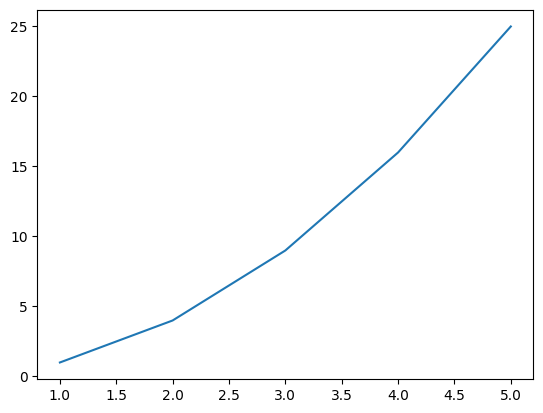

In [ ]:
from matplotlib import pyplot as plt
class MyClass:
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def make_plot(self):
        plt.plot(self.x,self.y)
        plt.show()

obj=MyClass([1,2,3,4,5],[1,4,9,16,25])
obj.make_plot()